# Семинар 9

# Введение в итерационные методы

## Оптимальный шаг в методе Ричардсона

- Решение линейной системы 

$$ Ax = b $$

- Метод Ричардсона 

$$ x_{k+1} = x_k - \tau (Ax_k - b) = (I - \tau A)x_k + \tau b$$

- Оптимальный $\tau$ для $A = A^* \succ 0$

$$ \tau^* = \frac{2}{\lambda_{\max} + \lambda_{\min}} $$

#### Как его получить?

- Найдём минимум $\| I - \tau A \|_2 = \lambda_{\max}(I - \tau A) = \max (|1 - \tau \lambda_{\max}(A)|, |1 - \tau \lambda_{\min} (A)|)$
- Две "v" образные функции
- Нарисуем функцию максимум от них
- Минимум максимума – это точка в которое они равны!
- $1 - \tau^* \lambda_{\max}(A) = -1 + \tau^* \lambda_{\min}(A)$
- Получаем ответ!

## Метод сопряжённых градиентов: напоминание

- Главный метод решения большой разреженной линейной системы с симметричной положительно-определённой матрицей
- Требует знания процедуры умножения матрицы на вектор
- Чувствителен к кластеризации спектра – чем менее равномерен спектр, тем лучше сходимость

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
n = 1000


# Random
A = np.random.randn(n, n)
mu = 1
A = A.T.dot(A) + mu * np.eye(n)

# Clustered eigenvalues
# A = np.diagflat([np.ones(n//4), 10 * np.ones(n//4), 100*np.ones(n//4), 1000* np.ones(n//4)])
# U = np.random.rand(n, n)
# Q, _ = np.linalg.qr(U)
# A = Q.dot(A).dot(Q.T)

# A = (A + A.T) * 0.5
print("A is normal matrix: ||AA* - A*A|| =", np.linalg.norm(A.dot(A.T) - A.T.dot(A)))
print("Condition number = {}".format(np.linalg.cond(A)))

b = np.random.randn(n)
# _, eigvec = np.linalg.eigh(A)
# b = eigvec[:, 0]


# Hilbert matrix
# A = np.array([[1.0 / (i+j - 1) for i in range(1, n+1)] for j in range(1, n+1)])
# b = np.ones(n)

A is normal matrix: ||AA* - A*A|| = 0.0
Condition number = 3974.134612416319


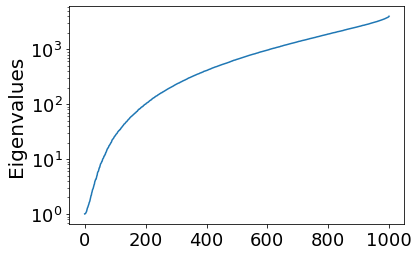

In [6]:
eigs = np.linalg.eigvals(A)
# print(eigs)
plt.semilogy(np.unique(eigs))
plt.ylabel("Eigenvalues", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

In [7]:
import scipy.sparse.linalg as spsplin
res_hist = []
def callback(x):
    res_hist.append(np.linalg.norm(A @ x - b) / np.linalg.norm(b))
    
x, info = spsplin.cg(A, b, maxiter=n, tol=1e-8, callback=callback)
print(np.linalg.norm(A @ x - b))
print(info)
x_lu = np.linalg.solve(A, b)
print(np.linalg.norm(A @ x_lu - b))

# %timeit spsplin.cg(A, b, maxiter=n, tol=1e-10)
# %timeit np.linalg.solve(A, b)

3.1039134111320533e-07
0
4.096102355984093e-12


568


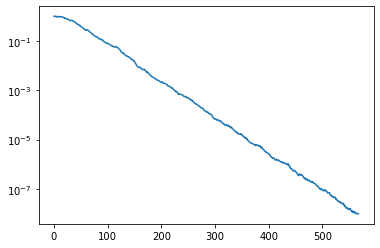

In [8]:
plt.semilogy(res_hist)
print(len(res_hist))

## Регуляризация задачи наименьших квадратов

$$ \| Ax - b \|_2^2 + \lambda \|x\|_2^2 \to \min_x $$ 

- Решение записывается аналогично

$$ (A^{\top}A + \lambda I)x = A^{\top}b $$

- Каким свойством теперь обладает матрица по сравнению с исходной постановкой без регуляризации?

In [107]:
m, n = 1000, 100
A = np.random.randn(m, n)
x_true = np.random.randn(n)
b = A @ x_true + 0.01 * np.random.randn(m)

In [108]:
lam = 1
x = spsplin.lsmr(A, b, damp=lam)[0]
print(np.linalg.norm(A @ x - b)**2 + lam * np.linalg.norm(x)**2)

99.93691827234433


In [109]:
lin_op = spsplin.LinearOperator((n, n), 
        matvec=lambda x: lam * x + A.T @ (A @ x))

rhs = A.T @ b 
res_hist = []
def callback(x):
    res_hist.append(np.linalg.norm(A.T @ (A @ x) + lam * x - rhs) / np.linalg.norm(rhs))
    
x_cg, _ = spsplin.cg(lin_op, rhs, callback=callback)
print(np.linalg.norm(A @ x_cg - b)**2 + lam * np.linalg.norm(x_cg)**2)

99.93692851337067


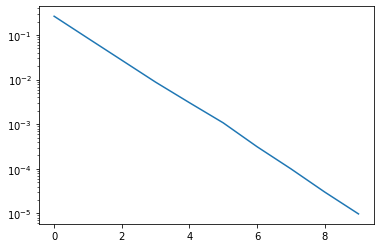

In [110]:
plt.semilogy(res_hist)